# Determining ERA5 climatology

## ERA5 climatology for deepsoiltemperture CCLM
Problem:
T_Cl in the extpar of cclm is (presumably) the reason for the cold bias in all cclm runs.
Therefore, we are investigating how other datasets could contribute to a smaller cold bias.

In [3]:
import sys
parent_directory = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/fiens/ValEnsPy/evaluation_cclm/'
sys.path.append(parent_directory)
functions_directory = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/fiens/ValEnsPy/src/valenspy/'
sys.path.append(functions_directory)

from pathlib import Path

import xarray as xr
import pandas as pd

import valenspy as vp #The Valenspy package
from valenspy.input.converter_functions import ERA5_to_CF, CCLM_to_CF
from valenspy._utilities import load_xarray_from_data_sources
from valenspy.processing.select import select_region
from valenspy.diagnostic.visualizations import *
#from eval_functions import *
from yaml import safe_load

import numpy as np
import matplotlib.pyplot as plt

In [387]:
def geo_to_rot(coord, ds):
    ###
    # Converts a geographic (lon,lat) point to an (rlon,rlat) point
    # => coord: geographic lon - lat couple (degrees) => list or tuple
    # => ds: xarray dataset of a CCLM file
    ###
    # Read in COSMO-CLM data

    rp_lat = float(ds.rotated_pole.grid_north_pole_latitude)
    rp_lon = float(ds.rotated_pole.grid_north_pole_longitude)
    # Convert 
    co = np.deg2rad(coord)
    rp_lat = np.deg2rad(rp_lat); rp_lon = np.deg2rad(rp_lon)
    p_rlat = np.arcsin(np.sin(co[1])*np.sin(rp_lat) + np.cos(co[1])*np.cos(rp_lat)*np.cos(co[0]-rp_lon)) 
    p_rlon = np.arctan((np.cos(co[1])*np.sin(co[0]-rp_lon)) / (np.cos(co[1])*np.sin(rp_lat)*np.cos(co[0]-rp_lon) - np.sin(co[1])*np.cos(rp_lat))) 
    p_rlat = np.rad2deg(p_rlat); p_rlon = np.rad2deg(p_rlon)
    # Return rlon-rlat couple
    return [p_rlon,p_rlat]

In [388]:
machine = "hortense"
variable = "stl4"
ref_dataset = "ERA5"
startyear = 1995
endyear = 1995
method = 'mean'
startmonth = 6
endmonth = 8

In [389]:
# Loading ECOCLIMAP data
ec_dir = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/wouterl/exp_fiens_eval_setup_JJA1995_NUKLEUS_transient_aerosol_ECOCLIMAP/ext/'
ec_file = ec_dir + 'extpar_1995.nc'
ec_extp = xr.open_mfdataset(ec_file, combine="by_coords", chunks="auto")


In [390]:
# Loading ECOCLIMAP data
gc_dir = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/wouterl/exp_fiens_eval_setup_JJA1995_transient_aerosol/ext/'
gc_file = gc_dir + 'extpar_1995.nc'
gc_extp = xr.open_mfdataset(gc_file, combine="by_coords", chunks="auto")

In [391]:
# ERA5 files (manually loaded and converted)
data_dir = '/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/hourly/soil_temperature_level_4/'
ERA5_deepsoil_files = os.listdir(data_dir)


In [392]:
# Processing data into file with averages
# Filtering climatology files based on year range
climatology_files = [
    s for s in ERA5_deepsoil_files 
    if startyear <= int(s[-7:-3]) <= endyear
]
climatology_files = np.sort(climatology_files)



In [393]:
# define bounds 
bounds = {'europe':
                    {'lat_bounds': [70,35], 
                    'lon_bounds': [-15,40]}, 
        'belgium': 
                    {'lat_bounds': [52,49], 
                    'lon_bounds': [2,7]}}

In [394]:
region = 'europe'
lat_bounds = bounds[region]['lat_bounds']
lon_bounds = bounds[region]['lon_bounds']

In [395]:
# savepath = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/ERA5/'
# filename = ref_dataset + '_' + variable + '_' + str(startyear) + '-' + str(endyear) + '_' + method + '.nc'
# print(filename)
# if os.path.exists(savepath + filename):
#     print(f"The file '{filename}' already exists.")
#     ds = xr.open_mfdataset(savepath + filename)
#     da = ds['stl4']
# else:
#     netcdf_files = [os.path.join(data_dir, f) for f in climatology_files]
#     # Open multiple NetCDF files as a single xarray dataset
#     ds = xr.open_mfdataset(netcdf_files, combine='by_coords', engine='netcdf4', chunks="auto")
#     ds = ds.rename({'latitude' : 'lat', 'longitude' : 'lon', 'valid_time' : 'time'})
#     ds = ds.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1]))
#     if method == 'min':
#         da = ds['stl4'].min('time').compute()
#     if method == 'median':
#         da = ds['stl4'].median('time').compute()
#     elif method == 'mean':
#         da = ds['stl4'].mean('time').compute()
#     elif method == 'max':
#         da = ds['stl4'].max('time').compute()
#     elif method == 'P10':
#         da = ds['stl4'].quantile(q = 10, dim = 'time').compute()
#     else:
#         print("Method is not included")
#     da.to_netcdf(savepath + filename)


In [396]:
ds['stl4']

<xarray.DataArray 'stl4' (lat: 13, lon: 21)> Size: 1kB
dask.array<open_dataset-stl4, shape=(13, 21), dtype=float32, chunksize=(13, 21), chunktype=numpy.ndarray>
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 104B 52.0 51.75 51.5 51.25 ... 49.75 49.5 49.25 49.0
  * lon      (lon) float64 168B 2.0 2.25 2.5 2.75 3.0 ... 6.0 6.25 6.5 6.75 7.0
Attributes: (12/33)
    GRIB_paramId:                             236
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      47107
    GRIB_typeOfLevel:                         depthBelowLandLayer
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_units:                               K
    long_name:                                Soil temperature level 4
    units:                                    K
    standard_name:                            unknown
    GRIB_depthBelowLandLayer:                 100.0
    dataset:                                  mean ERA5 level4

In [397]:
# Zomer 1995
savepath = '/dodrio/scratch/projects/2022_200/RCS/CORDEXBE2/postprocessing/ERA5/'
filename = ref_dataset + '_' + variable + '_' + str(startyear) + '-' + str(endyear) + '_JJA_' + method + '.nc'
print(filename)
if os.path.exists(savepath + filename):
    print(f"The file '{filename}' already exists.")
    ds = xr.open_mfdataset(savepath + filename)
    da = ds['stl4']
else:
    netcdf_files = [os.path.join(data_dir, f) for f in climatology_files]
    # Open multiple NetCDF files as a single xarray dataset
    ds = xr.open_mfdataset(netcdf_files, combine='by_coords', engine='netcdf4', chunks="auto")
    ds = ds.rename({'latitude' : 'lat', 'longitude' : 'lon', 'valid_time' : 'time'})
    ds = ds.sel(lon=slice(lon_bounds[0],lon_bounds[1]),lat=slice(lat_bounds[0], lat_bounds[1]))
    da = ds['stl4']
    da = da.sel(time = da.time.dt.month.isin([6,7,8]))
    if method == 'min':
        da = da.min('time').compute()
    if method == 'median':
        da = da.median('time').compute()
    elif method == 'mean':
        da = da.mean('time').compute()
    elif method == 'max':
        da = da.max('time').compute()
    elif method == 'P10':
        da = ds.quantile(q = 10, dim = 'time').compute()
    else:
        print("Method is not included")
    da.to_netcdf(savepath + filename)


ERA5_stl4_1995-1995_JJA_mean.nc


In [399]:
gridfile = data_dir + climatology_files[0]
da_ec_extp_soil = ec_extp["T_CL"]
ec_remap = remap_cdo(ds = da_ec_extp_soil, target_grid = gridfile, remap_method="bil")
da_gc_extp_soil = gc_extp["T_CL"]
gc_remap = remap_cdo(ds = da_gc_extp_soil, target_grid = gridfile, remap_method="bil")


In [400]:
da_ec_remap = ec_remap['T_CL']
da_ec_remap.attrs['long_name'] = 'Deepsoil Temperature'
da_ec_remap.attrs['units'] = 'K'
da_ec_remap.attrs['dataset'] = 'CRU (EC)'
# da_ec_remap = ec_remap.to_array()
da_gc_remap = gc_remap['T_CL']
da_gc_remap.attrs['long_name'] = 'Deepsoil Temperature'
da_gc_remap.attrs['units'] = 'K'
da_gc_remap.attrs['dataset'] = 'CRU (GC)'
# da_ec_remap = ec_remap.to_array()
da.attrs['dataset'] = method + ' ERA5 level4'

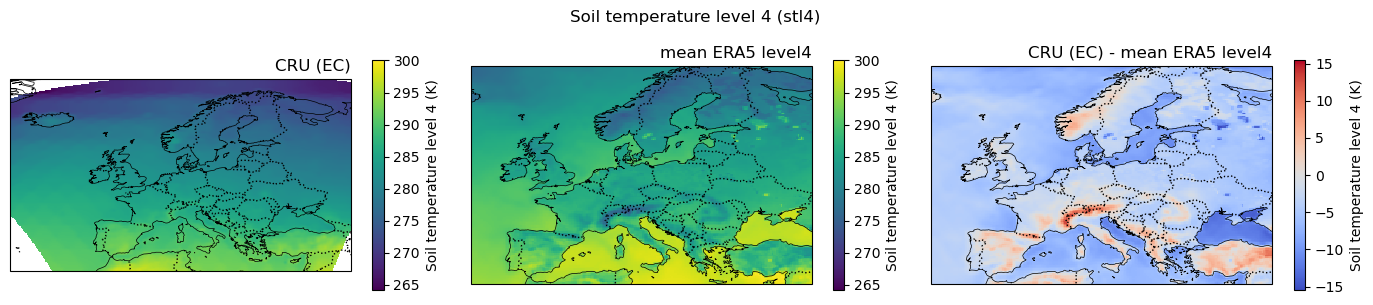

In [401]:
da_ref1 = da
da_mod1 = da_ec_remap
da_diff1 = da_mod1 - da_ref1
ax = plot_maps_mod_ref_diff(da_ref = da_ref1,  da_mod = da_mod1,  da_diff = da_diff1)

In [402]:
# da_ref2 = da
# da_mod2 = da_gc_remap
# da_diff2 = da_mod2 - da_ref2
# ax = plot_maps_mod_ref_diff(da_ref = da_ref2,  da_mod = da_mod2,  da_diff = da_diff2)

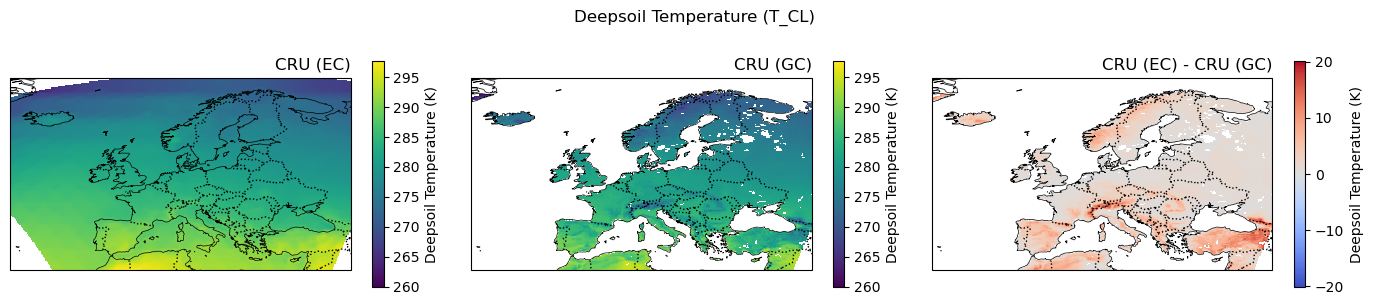

In [403]:
da_ref3 = da_gc_remap
da_mod3 = da_ec_remap
da_diff3 = da_mod3 - da_ref3
ax = plot_maps_mod_ref_diff(da_ref = da_ref3,  da_mod = da_mod3,  da_diff = da_diff3)

In [404]:
region = 'belgium'
lat_bounds = bounds[region]['lat_bounds']
lon_bounds = bounds[region]['lon_bounds']

In [405]:
da = da.sortby('lat')

In [406]:
da_region = sel_region(da, region=region)


In [407]:
da_ec_remap_region = sel_region(da_ec_remap, region=region)

da_ec_remap_region.attrs['long_name'] = 'Deepsoil Temperature'
da_ec_remap_region.attrs['units'] = 'K'
da_ec_remap_region.attrs['dataset'] = 'CRU (EC)'

da_gc_remap_region = sel_region(da_gc_remap, region=region)

da_gc_remap_region.attrs['long_name'] = 'Deepsoil Temperature'
da_gc_remap_region.attrs['units'] = 'K'
da_gc_remap_region.attrs['dataset'] = 'CRU (GC)'

In [408]:

da_diff_region_gc = da_gc_remap_region - da_region
da_diff_region_ec_gc = da_ec_remap_region - da_gc_remap_region

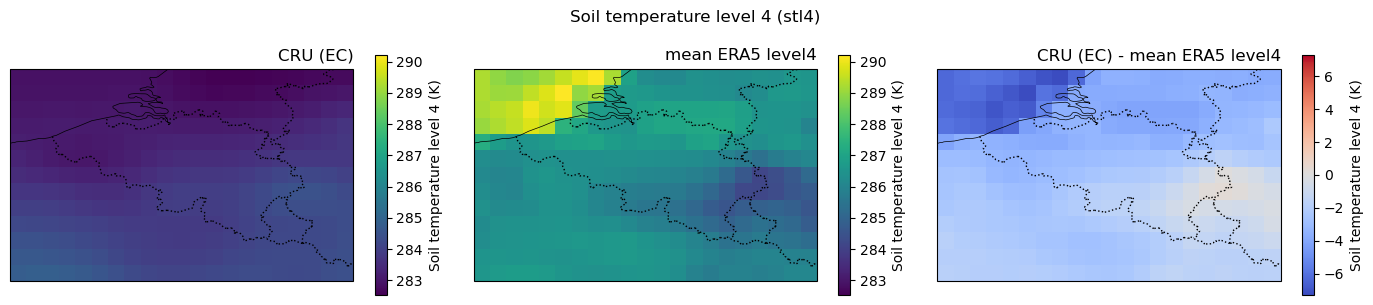

In [409]:
da_mod4 = da_ec_remap_region
da_ref4 =da_region
da_diff4 = da_mod4 - da_ref4
ax = plot_maps_mod_ref_diff(da_ref = da_ref4,  da_mod = da_mod4,  da_diff = da_diff4)

In [410]:
# da_mod5 = da_gc_remap_region
# da_ref5 = da_region
# da_diff5 = da_mod5 - da_ref5
# ax = plot_maps_mod_ref_diff(da_ref = da_ref5,  da_mod = da_mod5,  da_diff = da_diff5)

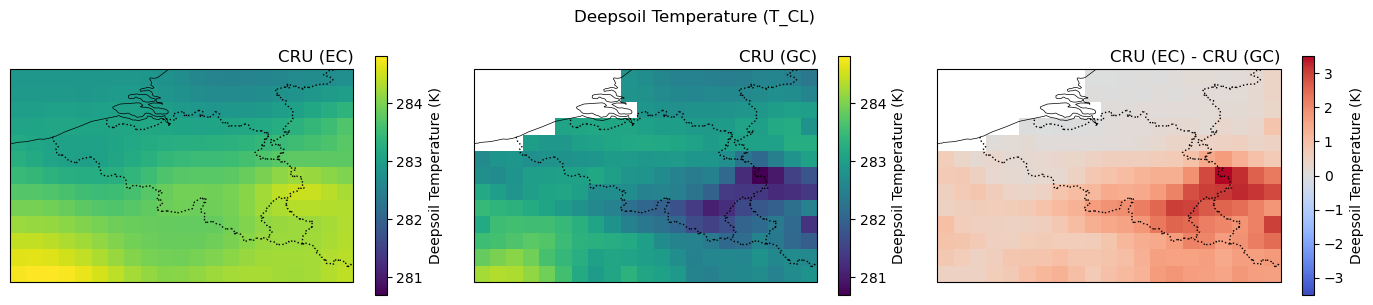

In [411]:
da_ref6 = da_gc_remap_region
da_mod6 = da_ec_remap_region
da_diff6 = da_mod6 - da_ref6
ax = plot_maps_mod_ref_diff(da_ref = da_ref6,  da_mod = da_mod6,  da_diff = da_diff6)